In [58]:
import mxnet as mx
import mxnet.gluon.probability as mgp
from mxnet import np, npx
import matplotlib.pyplot as plt
import numpy as onp
from mxnet import autograd, gluon
import seaborn as sns
npx.set_np()

# Distributions

## Plotting distributions

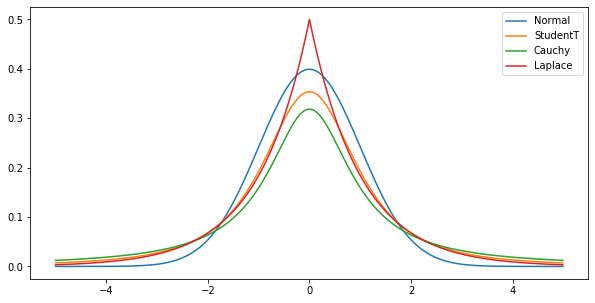

In [63]:
# 
normal = mgp.Normal(np.zeros((1,)), 1)
T = mgp.StudentT(df=2)
C = mgp.Cauchy(0, np.ones((1,)))
L = mgp.Laplace(0, 1)
x = np.arange(-5, 5, 0.01)
_, ax = plt.subplots(figsize=(10, 5))
ax.plot(x.asnumpy(), normal.pdf(x).asnumpy(), label='Normal')
ax.plot(x.asnumpy(), T.pdf(x).asnumpy(), label='StudentT')
ax.plot(x.asnumpy(), C.pdf(x).asnumpy(), label='Cauchy')
ax.plot(x.asnumpy(), L.pdf(x).asnumpy(), label='Laplace')
ax.legend()

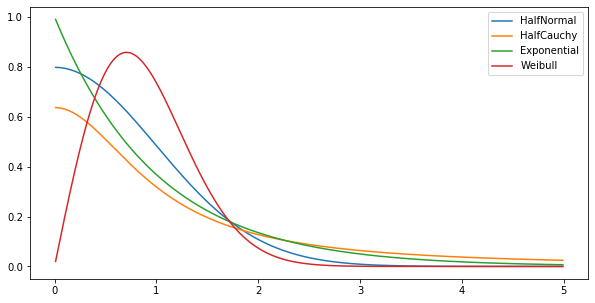

In [87]:
HN = mgp.HalfNormal(1.0)
HC = mgp.HalfCauchy(1.0)
E = mgp.Exponential(1.0)
W = mgp.Weibull(2.0)
x = np.arange(0.01, 5, 0.01)
_, ax = plt.subplots(figsize=(10, 5))
ax.plot(x.asnumpy(), HN.pdf(x).asnumpy(), label='HalfNormal')
ax.plot(x.asnumpy(), HC.pdf(x).asnumpy(), label='HalfCauchy')
ax.plot(x.asnumpy(), E.pdf(x).asnumpy(), label='Exponential')
ax.plot(x.asnumpy(), W.pdf(x).asnumpy(), label='Weibull')
ax.legend()

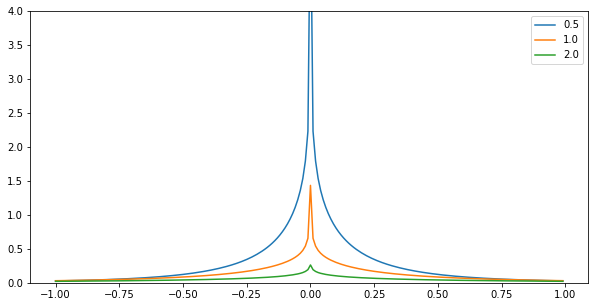

In [134]:
# Horseshoe prior
x = np.arange(-1, 1, 0.01)
_, ax = plt.subplots(figsize=(10, 5))
ax.set_ylim([0, 4])
sample_size = (10000,1)
for tau in [0.5, 1.0, 2.0]:
    sigma = mgp.HalfCauchy(tau)
    sigma_samples = sigma.sample(sample_size)
    mixture_coef = sigma.pdf(sigma_samples)
    scale_mixture = mgp.Normal(0, sigma_samples)
    density = (scale_mixture.pdf(np.expand_dims(x, 0)) * mixture_coef).mean(0)
    ax.plot(x.asnumpy(), density.asnumpy(), label=tau)
ax.legend()

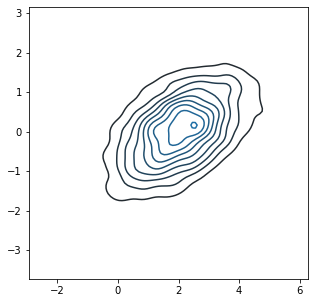

In [25]:
loc = np.array([2.0, 0.0])
cov = np.array([[1.0, 0.6], [0.6, 1.0]])
mvn = mgp.MultivariateNormal(loc, cov=cov)
_, ax = plt.subplots(figsize=(5, 5))
mvn_samples = mvn.sample(3000).asnumpy()
sns.kdeplot(mvn_samples[:, 0], mvn_samples[:, 1])

In [47]:
dist1 = mgp.Gamma(2.0, 1.0)
dist2 = mgp.Gamma(1.0, 1.0)
print(mgp.kl_divergence(dist1, dist2))

0.42278432846069336


In [48]:
print(mgp.empirical_kl(dist1, dist2, n_samples=5000))

0.42641777


## Confidence Interval of Normal distribution

Percent of samples lie in 95% CI: 0.9559999704360962


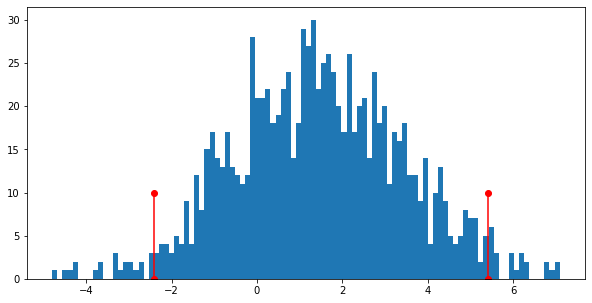

In [135]:
mean = 1.5
std = 2.0
alpha = 0.05
num_samples = 1000
dist = mgp.Normal(mean, std)
_, ax = plt.subplots(figsize=(10, 5))
samples = dist.sample(num_samples)
ax.hist(samples.asnumpy(), bins=100)
ci_0 = dist.icdf(1 - alpha / 2)
ci_1 = dist.icdf(alpha / 2)
ax.plot([ci_0, ci_0], [0, 10], [ci_1, ci_1], [0, 10], marker='o', c='r')
print("Percent of samples lie in 95% CI: {}".format(
    ((samples > ci_1) & (samples < ci_0)).sum() / num_samples)
)

## Sampling operations are differentiable (pathwise gradient)

In [14]:
prob = np.array([0.1, 0.2, 0.1, 0.6])
prob.attach_grad()
categorical = mgp.OneHotCategorical(num_events=4, prob=prob)
relaxed_categorical = mgp.RelaxedOneHotCategorical(T=1.0, num_events=4, prob=prob)
print(categorical.has_grad)
print(relaxed_categorical.has_grad)

False
True


[ 7.0282691e-10 -1.9352746e-09  1.2647361e-09  4.9712318e-12]


<BarContainer object of 4 artists>

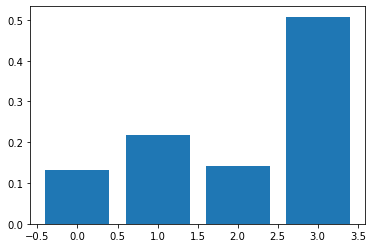

In [15]:
with autograd.record():
    gs_samples = relaxed_categorical.sample(1000).mean(0)
gs_samples.backward()
print(prob.grad)
plt.bar([0,1,2,3], gs_samples.asnumpy())

# Transformations

Construct logit-normal distribution with sigmoid transform:

```python
class SigmoidTransform(Transformation):
    r"""
    Perform *pointwise* sigmoid transform: y = 1 / (1 + exp(-x)).
    """
    bijective = True
    sign = 1

    def _forward_compute(self, x):
        F = self.F
        return _clip_prob(F.npx.sigmoid(x), F)

    def _inverse_compute(self, y):
        F = self.F
        clipped_prob = _clip_prob(y, F)
        return F.np.log(clipped_prob) - F.np.log1p(-clipped_prob)

    def log_det_jacobian(self, x, y):
        F = self.F
        log = F.np.log
        exp = F.np.exp
        softplus_fn = lambda x: log(1 + exp(x))
        return -softplus_fn(-x) - softplus_fn(x)
```

In [50]:
logit_normal = mgp.TransformedDistribution(
    base_dist=mgp.Normal(np.array([2.0]),np.array([1.0])),
    transforms=mgp.SigmoidTransform()
)

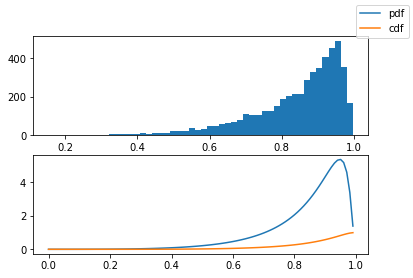

In [57]:
fig, axes = plt.subplots(2)
# Sampling from logit-normal
axes[0].hist(logit_normal.sample(5000).asnumpy(), bins=50)
x = np.arange(0, 1, 0.01)
# Closed-form density
axes[1].plot(x.asnumpy(), logit_normal.pdf(x).asnumpy(), label='pdf') 
axes[1].plot(x.asnumpy(), logit_normal.cdf(x).asnumpy(), label='cdf') 
fig.legend()

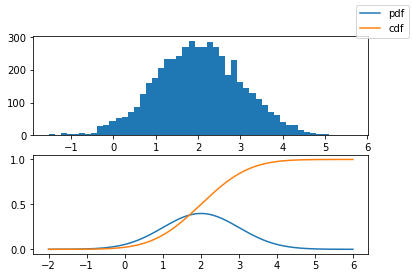

In [56]:
# Transform logit-normal back to normal
origin_normal = mgp.TransformedDistribution(
    base_dist=logit_normal,
    transforms=mgp.SigmoidTransform().inv
)

fig, axes = plt.subplots(2)
# Sampling from logit-normal
axes[0].hist(origin_normal.sample(5000).asnumpy(), bins=50)
x = np.arange(-2, 6, 0.01)
# Closed-form density
axes[1].plot(x.asnumpy(), origin_normal.pdf(x).asnumpy(), label='pdf') 
axes[1].plot(x.asnumpy(), origin_normal.cdf(x).asnumpy(), label='cdf') 
fig.legend()